In [1]:
# Basic python packages
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Statistical tests and plots packages
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#### Big, beautiful dataframe for TSAF

## 1. Get gasoline stock and prices

All series imported from APIs and starting in Jan. 2010

Weekly series will be averaged for the final dataframe

##### 1.1 Gasoline Stock

In [2]:
API_KEY = "JB0mjBHe8ebPVRafXPnetbaoNGigyEQTrYU3aoe3"
STOCKS_URL = "https://api.eia.gov/v2/petroleum/stoc/wstk/data/"

# 1. Setup Parameters for Stocks (using your provided structure)
params_stocks = {
    "api_key": API_KEY,
    "frequency": "weekly",
    "data[]": "value",
    "facets[duoarea][]": "NUS",
    "facets[process][]": "SAE",
    "facets[product][]": "EPM0",
    "facets[series][]": "WGTSTUS1",
    "start": "2010-01-01",
    "end": "2026-01-31",
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 5000
}
response = requests.get(STOCKS_URL, params=params_stocks)
data = response.json()

#Extract the actual data rows into a Pandas DataFrame
gasoline_stock_weekly = pd.DataFrame(data['response']['data'])
gasoline_stock_weekly = gasoline_stock_weekly[['period', 'value']]

gasoline_stock_weekly['period'] = pd.to_datetime(gasoline_stock_weekly['period']) #makes sure the date is in Date format
gasoline_stock_weekly = gasoline_stock_weekly.set_index('period')
gasoline_data = gasoline_stock_weekly.sort_index(ascending=True)
gasoline_stock_weekly['value'] = pd.to_numeric(gasoline_stock_weekly['value'], errors='coerce')
gasoline_stock_weekly.columns = ["Gasoline_Stock"] #rename the columns
gasoline_stock_weekly.head()

,Gasoline_Stock
period,
2026-01-30,257898
2026-01-23,257213
2026-01-16,256990
2026-01-09,251013
2026-01-02,242036


#### 1.2 Gasoline prices (monthly)

In [3]:
API_KEY = "JB0mjBHe8ebPVRafXPnetbaoNGigyEQTrYU3aoe3"
URL = "https://api.eia.gov/v2/petroleum/pri/gnd/data/"

# Define parameters for Monthly Retail Gasoline Prices
params_monthly = {
    "api_key": API_KEY,
    "frequency": "monthly", # Switched from 'weekly' to 'monthly'
    "data[]": "value",
    "facets[series][]": "EMM_EPMR_PTE_NUS_DPG", 
    "start": "2010-01-01",
    "end": "2026-01-31",
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 5000
}

response = requests.get(URL, params=params_monthly)
data = response.json()

# 3. DATAFRAME PROCESSING
gas_prices_monthly = pd.DataFrame(data['response']['data'])

# EIA Monthly data returns period as 'YYYY-MM'
gas_prices_monthly['Date'] = pd.to_datetime(gas_prices_monthly['period'])
gas_prices_monthly = gas_prices_monthly[['Date', 'value']].rename(columns={'value': 'Monthly_Gas_Price'})

# Sort and clean
gas_prices_monthly = gas_prices_monthly.sort_values('Date').set_index('Date')
gas_prices_monthly['Monthly_Gas_Price'] = pd.to_numeric(gas_prices_monthly['Monthly_Gas_Price'], errors='coerce')

print(gas_prices_monthly.head())

            Monthly_Gas_Price
Date                         
2010-01-01              2.715
2010-02-01              2.644
2010-03-01              2.772
2010-04-01              2.848
2010-05-01              2.836


#### 1.3 Gasoline prices (weekly)

In [4]:
API_KEY = "JB0mjBHe8ebPVRafXPnetbaoNGigyEQTrYU3aoe3"
# URL es el mismo que para montly data

params_weekly = {
    "api_key": API_KEY,
    "frequency": "weekly", # Set to weekly
    "data[]": "value",
    "facets[series][]": "EMM_EPMR_PTE_NUS_DPG", 
    "start": "2010-01-01",
    "end": "2026-01-31",
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 5000
}

response = requests.get(URL, params=params_weekly)
data = response.json()

gas_prices_weekly = pd.DataFrame(data['response']['data'])

gas_prices_weekly['Date'] = pd.to_datetime(gas_prices_weekly['period'])
gas_prices_weekly = gas_prices_weekly[['Date', 'value']].rename(columns={'value': 'Weekly_Gas_Price'})

# Sort and clean
gas_prices_weekly = gas_prices_weekly.sort_values('Date').set_index('Date')
gas_prices_weekly['Weekly_Gas_Price'] = pd.to_numeric(gas_prices_weekly['Weekly_Gas_Price'], errors='coerce')

print(gas_prices_weekly.tail()) # Show the most recent dates

            Weekly_Gas_Price
Date                        
2025-12-29             2.811
2026-01-05             2.796
2026-01-12             2.779
2026-01-19             2.806
2026-01-26             2.853


## 2. Exogenous variables

### 2.1 Inflation ex. food and regulated items (monthly).
 From [here](https://fred.stlouisfed.org/series/CORESTICKM159SFRBATL)

This is the percent change from a year before, not the index

In [5]:
FRED_API_KEY = "3213b1a82c8c665924ce8cc536c30814"
SERIES_ID = "CORESTICKM159SFRBATL"
URL = "https://api.stlouisfed.org/fred/series/observations"

# Parameters for FRED API
params = {
    "api_key": FRED_API_KEY,
    "series_id": SERIES_ID,
    "file_type": "json",
    "observation_start": "2010-01-01",
    "observation_end": "2026-01-31"
}

print(f"Fetching {SERIES_ID} from FRED...")
response = requests.get(URL, params=params)
data = response.json()

# 3. DATAFRAME PROCESSING
# FRED returns data in 'observations' list
inflation = pd.DataFrame(data['observations'])

# Clean up dates and values
inflation['Date'] = pd.to_datetime(inflation['date'])
inflation['Value'] = pd.to_numeric(inflation['value'], errors='coerce')

# Select relevant columns and set index
inflation = inflation[['Date', 'Value']].rename(columns={'Value': 'Core_Sticky_CPI'})
inflation = inflation.set_index('Date').sort_index()

print(inflation.head())

Fetching CORESTICKM159SFRBATL from FRED...
            Core_Sticky_CPI
Date                       
2010-01-01         1.170764
2010-02-01         1.048684
2010-03-01         0.925503
2010-04-01         0.869413
2010-05-01         0.793302


### 2.2 Crude Oil imports into the US (monthly)

Millions of barrels
The original data shows several "types" of crude oil. I will download all of them and later we can add them or see if each one separately is better for the model.

In [6]:
# 1. CONFIGURATION
API_KEY = "JB0mjBHe8ebPVRafXPnetbaoNGigyEQTrYU3aoe3" # Note: Be careful sharing API keys publicly!
URL = "https://api.eia.gov/v2/crude-oil-imports/data/"

params = {
    "api_key": API_KEY,
    "frequency": "monthly",
    "data[0]": "quantity",
    "facets[destinationType][]": "US",
    "start": "2010-01",
    "end": "2025-11",
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "length": 5000
}


all_data = [] # Empty list to store all our batches of data
offset = 0

while True:
    params["offset"] = offset # Update the offset for each loop
    response = requests.get(URL, params=params)
    json_data = response.json()
    
    # Check if the response contains data
    if 'response' in json_data and 'data' in json_data['response']:
        batch_data = json_data['response']['data']
        
        # If the batch is empty, we've reached the end of the data
        if not batch_data:
            break
            
        all_data.extend(batch_data)     
        # If the API returned fewer records than our max length, we are on the last page
        if len(batch_data) < 5000:
            break
            
        # Increase the offset to get the next page on the next loop
        offset += 5000 
    else:
        print(f"Error or end of data at offset {offset}. Check API response.")
        break

df_raw = pd.DataFrame(all_data)

# Convert and clean
df_raw['Date'] = pd.to_datetime(df_raw['period'])
df_raw['quantity'] = pd.to_numeric(df_raw['quantity'], errors='coerce')

# Group by Date and Grade (this sums up all countries for each grade)
df_grouped = df_raw.groupby(['Date', 'gradeName'])['quantity'].sum().reset_index()

# Pivot so each grade becomes a column
oil_imports_df = df_grouped.pivot(index='Date', columns='gradeName', values='quantity')

# --- DYNAMIC RENAMING STEP ---
oil_imports_df.columns = [f"import_{col.lower().replace(' ', '_')}" for col in oil_imports_df.columns]

# Final cleanup
oil_imports_df = oil_imports_df.fillna(0).sort_index()

print(f"Total months of data retrieved: {len(oil_imports_df)}")
print(oil_imports_df.head())


Total months of data retrieved: 191
            import_heavy_sour  import_heavy_sweet  import_light_sour  \
Date                                                                   
2010-01-01             430340               30820              66372   
2010-02-01             401212               28848              55060   
2010-03-01             475960               20468              69724   
2010-04-01             461592               24848              70352   
2010-05-01             518760               28408              62404   

            import_light_sweet  import_medium  
Date                                           
2010-01-01              219020         351720  
2010-02-01              203584         323896  
2010-03-01              209576         420404  
2010-04-01              208680         445872  
2010-05-01              199528         432484  


### 2.3 Miles travelled by vehicles

Miles travelled by vehicles serves as a proxy of gasoline demand.

Originally the data is from US Federal Highway Administration, but is available at. [FRED](https://fred.stlouisfed.org/series/TRFVOLUSM227NFWA)

It has both a seasonally adjusted and not-seasonally adjusted serie. We will download both.


#### 2.3.1: Not seasonally adjusted

In [7]:
FRED_API_KEY = "3213b1a82c8c665924ce8cc536c30814"
SERIES_ID = "TRFVOLUSM227NFWA"
URL = "https://api.stlouisfed.org/fred/series/observations"

params = {
    "api_key": FRED_API_KEY,  #same as for inflation
    "series_id": SERIES_ID,
    "file_type": "json",
    "observation_start": "2010-01-01",
    "observation_end": "2026-01-31"
}

response = requests.get(URL, params=params)
data = response.json()

# FRED data is nested in the 'observations' key
if 'observations' in data:
    Miles_NSA = pd.DataFrame(data['observations'])
    
    # Clean dates and values (FRED uses 'date' and 'value' as keys)
    Miles_NSA['Date'] = pd.to_datetime(Miles_NSA['date'])
    Miles_NSA['value'] = pd.to_numeric(Miles_NSA['value'], errors='coerce')
    
    # Format and Rename
    Miles_NSA = Miles_NSA[['Date', 'value']].rename(columns={'value': 'miles_traveled'})
    Miles_NSA = Miles_NSA.set_index('Date').sort_index()
    
    print(f"Retrieved {len(Miles_NSA)} months of travel data.")
    print(Miles_NSA.head())

Retrieved 192 months of travel data.
            miles_traveled
Date                      
2010-01-01        220839.0
2010-02-01        210635.0
2010-03-01        254238.0
2010-04-01        253936.0
2010-05-01        256927.0


#### 2.3.2: Seasonally adjusted series

In [8]:
FRED_API_KEY = "3213b1a82c8c665924ce8cc536c30814"
SERIES_ID = "TRFVOLUSM227SFWA"
URL = "https://api.stlouisfed.org/fred/series/observations"

params = {
    "api_key": FRED_API_KEY,  #same as for inflation
    "series_id": SERIES_ID,
    "file_type": "json",
    "observation_start": "2010-01-01",
    "observation_end": "2026-01-31"
}

response = requests.get(URL, params=params)
data = response.json()

# FRED data is nested in the 'observations' key
if 'observations' in data:
    Miles_SA = pd.DataFrame(data['observations'])
    
    # Clean dates and values (FRED uses 'date' and 'value' as keys)
    Miles_SA['Date'] = pd.to_datetime(Miles_SA['date'])
    Miles_SA['value'] = pd.to_numeric(Miles_SA['value'], errors='coerce')
    
    # Format and Rename
    Miles_SA = Miles_SA[['Date', 'value']].rename(columns={'value': 'miles_traveled'})
    Miles_SA = Miles_SA.set_index('Date').sort_index()
    
    print(f"Retrieved {len(Miles_SA)} months of travel data.")
    print(Miles_SA.head())

Retrieved 192 months of travel data.
            miles_traveled
Date                      
2010-01-01        242519.0
2010-02-01        241803.0
2010-03-01        248076.0
2010-04-01        249112.0
2010-05-01        247042.0


### 3.Merging data

For weekly data, calculate the mean to match the monthly seasonality

In [9]:
# Ensure the travel data has the specific names we want.
miles_nsa_clean = Miles_NSA.rename(columns={Miles_NSA.columns[0]: 'miles_traveled_nsa'})
miles_sa_clean = Miles_SA.rename(columns={Miles_SA.columns[0]: 'miles_traveled_sa'})

# Resample weekly data to monthly
gas_stock_monthly = gasoline_stock_weekly.resample('MS').mean()
gas_price_weekly_avg = gas_prices_weekly.resample('MS').mean()

monthly_dfs = [
    gas_stock_monthly,      # Should contain 'Gasoline_Stock'
    gas_prices_monthly,     # Should contain 'Monthly_Gas_Price'
    gas_price_weekly_avg,   # Should contain 'Weekly_Gas_Price'
    inflation,              # Should contain 'Core_Sticky_CPI'
    oil_imports_df,         # Contains the 5 'import_...' columns
    miles_nsa_clean,        # Now named 'miles_traveled_nsa'
    miles_sa_clean          # Now named 'miles_traveled_sa'
]


# Using 'outer' join to preserve all dates across the series
master_df = pd.concat(monthly_dfs, axis=1)

master_df.tail()

,Gasoline_Stock,Monthly_Gas_Price,Weekly_Gas_Price,Core_Sticky_CPI,import_heavy_sour,import_heavy_sweet,import_light_sour,import_light_sweet,import_medium,miles_traveled_nsa,miles_traveled_sa
2025-09-01,218727.50,3.166,3.16560,3.322171,472328.0,12460.0,43628.0,71756.0,167984.0,279611.0,278146.0
2025-10-01,214269.00,3.060,3.05975,3.077827,434736.0,5040.0,24084.0,56276.0,211192.0,291537.0,277645.0
2025-11-01,209195.25,3.050,3.04950,2.954815,418460.0,13248.0,13964.0,57076.0,190868.0,263087.0,277198.0
2025-12-01,227317.25,2.894,2.89440,3.006319,NaN,NaN,NaN,NaN,NaN,265776.0,277183.0
2026-01-01,253030.00,2.809,2.80850,2.979751,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# CHECK FOR MISSING VALUES
na_counts = master_df.isna().sum()
print(na_counts)

Gasoline_Stock        0
Monthly_Gas_Price     0
Weekly_Gas_Price      0
Core_Sticky_CPI       0
import_heavy_sour     2
import_heavy_sweet    2
import_light_sour     2
import_light_sweet    2
import_medium         2
miles_traveled_nsa    1
miles_traveled_sa     1
dtype: int64


Missing values are at the end of the dataframe because some series are not available until jan 2026.

We can fill the missing values using ffill()
Or we can just model without the last rows. **(model until November 2025)**

In [11]:
# Fill missing values using ffill (carrying forward the last available value)
master_df = master_df.ffill()

In [12]:
master_df.shape

(193, 11)

In [13]:
master_df.tail()

,Gasoline_Stock,Monthly_Gas_Price,Weekly_Gas_Price,Core_Sticky_CPI,import_heavy_sour,import_heavy_sweet,import_light_sour,import_light_sweet,import_medium,miles_traveled_nsa,miles_traveled_sa
2025-09-01,218727.50,3.166,3.16560,3.322171,472328.0,12460.0,43628.0,71756.0,167984.0,279611.0,278146.0
2025-10-01,214269.00,3.060,3.05975,3.077827,434736.0,5040.0,24084.0,56276.0,211192.0,291537.0,277645.0
2025-11-01,209195.25,3.050,3.04950,2.954815,418460.0,13248.0,13964.0,57076.0,190868.0,263087.0,277198.0
2025-12-01,227317.25,2.894,2.89440,3.006319,418460.0,13248.0,13964.0,57076.0,190868.0,265776.0,277183.0
2026-01-01,253030.00,2.809,2.80850,2.979751,418460.0,13248.0,13964.0,57076.0,190868.0,265776.0,277183.0


***"Data challenges" to include in ppt:***

***1. Matching granularity.***

Stocks are weekly but other variables are monthly.

Options:

- end of month
- 4 week average (we used this one)

***2. Missing values:***

- using ffill() instead of interpolation. If using interpolation it would be like "seeing" the future.

***3. (to-do) Check if we should sum the different oil imports or leave them like separated.***


## 4. EDA

In [14]:
master_df.info()

<class 'pandas.DataFrame'>
DatetimeIndex: 193 entries, 2010-01-01 to 2026-01-01
Freq: MS
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Gasoline_Stock      193 non-null    float64
 1   Monthly_Gas_Price   193 non-null    float64
 2   Weekly_Gas_Price    193 non-null    float64
 3   Core_Sticky_CPI     193 non-null    float64
 4   import_heavy_sour   193 non-null    float64
 5   import_heavy_sweet  193 non-null    float64
 6   import_light_sour   193 non-null    float64
 7   import_light_sweet  193 non-null    float64
 8   import_medium       193 non-null    float64
 9   miles_traveled_nsa  193 non-null    float64
 10  miles_traveled_sa   193 non-null    float64
dtypes: float64(11)
memory usage: 18.1 KB


In [15]:
# Create additional level of granularity for Yea, Year_Quarter, Year_Month, and	Week
master_df['Year'] = master_df.index.year
master_df['Year_Quarter'] = master_df.index.to_period("Q").astype(str)
master_df['Year_Month'] = master_df.index.strftime('%Y-%m')
master_df['Week'] = master_df.index.isocalendar().week.astype(int)

In [16]:
master_df.head(10)

,Gasoline_Stock,Monthly_Gas_Price,Weekly_Gas_Price,Core_Sticky_CPI,import_heavy_sour,import_heavy_sweet,import_light_sour,import_light_sweet,import_medium,miles_traveled_nsa,miles_traveled_sa,Year,Year_Quarter,Year_Month,Week
2010-01-01,225636.60,2.715,2.71500,1.170764,430340.0,30820.0,66372.0,219020.0,351720.0,220839.0,242519.0,2010,2010Q1,2010-01,53
2010-02-01,231405.75,2.644,2.64400,1.048684,401212.0,28848.0,55060.0,203584.0,323896.0,210635.0,241803.0,2010,2010Q1,2010-02,5
2010-03-01,226422.25,2.772,2.77160,0.925503,475960.0,20468.0,69724.0,209576.0,420404.0,254238.0,248076.0,2010,2010Q1,2010-03,9
2010-04-01,223452.80,2.848,2.84825,0.869413,461592.0,24848.0,70352.0,208680.0,445872.0,253936.0,249112.0,2010,2010Q2,2010-04,13
2010-05-01,221144.25,2.836,2.83620,0.793302,518760.0,28408.0,62404.0,199528.0,432484.0,256927.0,247042.0,2010,2010Q2,2010-05,17
2010-06-01,218252.25,2.732,2.73150,0.778013,456168.0,27044.0,73000.0,207188.0,477212.0,260083.0,247723.0,2010,2010Q2,2010-06,22
2010-07-01,221568.80,2.729,2.72875,0.744071,499016.0,43824.0,95400.0,190936.0,446788.0,265315.0,249293.0,2010,2010Q3,2010-07,26
2010-08-01,224437.25,2.730,2.72980,0.691116,503880.0,26744.0,85200.0,218800.0,401588.0,263837.0,249208.0,2010,2010Q3,2010-08,30
2010-09-01,224569.25,2.705,2.70500,0.663868,422788.0,36596.0,68196.0,207748.0,401440.0,244682.0,249084.0,2010,2010Q3,2010-09,35
2010-10-01,216928.20,2.801,2.80050,0.672334,446308.0,33248.0,56960.0,172572.0,380572.0,256395.0,249386.0,2010,2010Q4,2010-10,39


The Monthly_Gas_Price and the Weekly_Gas_Price are practically the same.

### 4.1 Time series plots by sales over time

In [17]:
# Check number of years in the dataset
print('Years in dataset:', master_df.index.year.unique())

Years in dataset: Index([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023, 2024, 2025, 2026],
      dtype='int32')


In [18]:
# Create a plot to check the sales over time by day
def plot_sales_over_time(df, date_colum, target_column, title, fig_size=(8,5),range_xticks=[]):
    print(title)
    # Plot dataframe 
    display(df.head(5))

    # Plot time series
    plt.figure(figsize=fig_size)
    plt.plot(df[date_colum], df[target_column], linestyle='-', marker='o')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel(target_column)
    if(len(range_xticks)>0):
        plt.xticks(range_xticks)

    plt.grid()
    plt.xticks(rotation=90)
    plt.show()

Average Close Price Over Time by Year


,Year,Monthly_Gas_Price
0,2010,2.780333
1,2011,3.520917
2,2012,3.625000
3,2013,3.505917
4,2014,3.363167


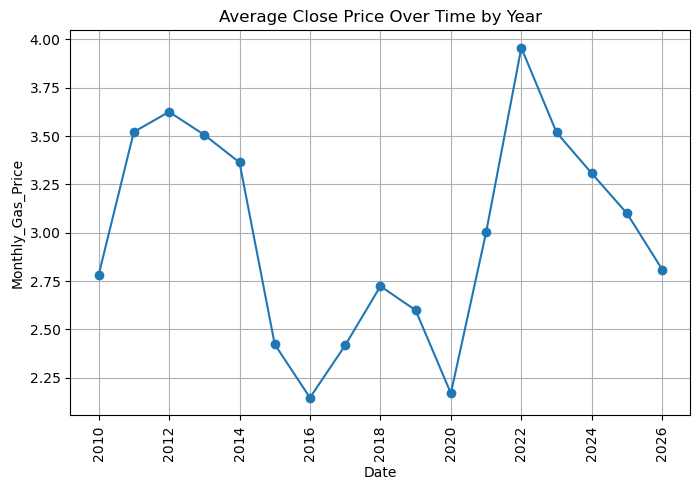

In [19]:
# Check sales over time for California by Year
df_cal_yearly = master_df.groupby(by='Year').agg({'Monthly_Gas_Price':'mean'}).reset_index()
plot_sales_over_time(df_cal_yearly, 'Year', 'Monthly_Gas_Price', 'Average Close Price Over Time by Year')

Average Monthly Gas Price Over Time by Year-Quarter


,Year_Quarter,Monthly_Gas_Price
0,2010Q1,2.710333
1,2010Q2,2.805333
2,2010Q3,2.721333
3,2010Q4,2.884333
4,2011Q1,3.289000


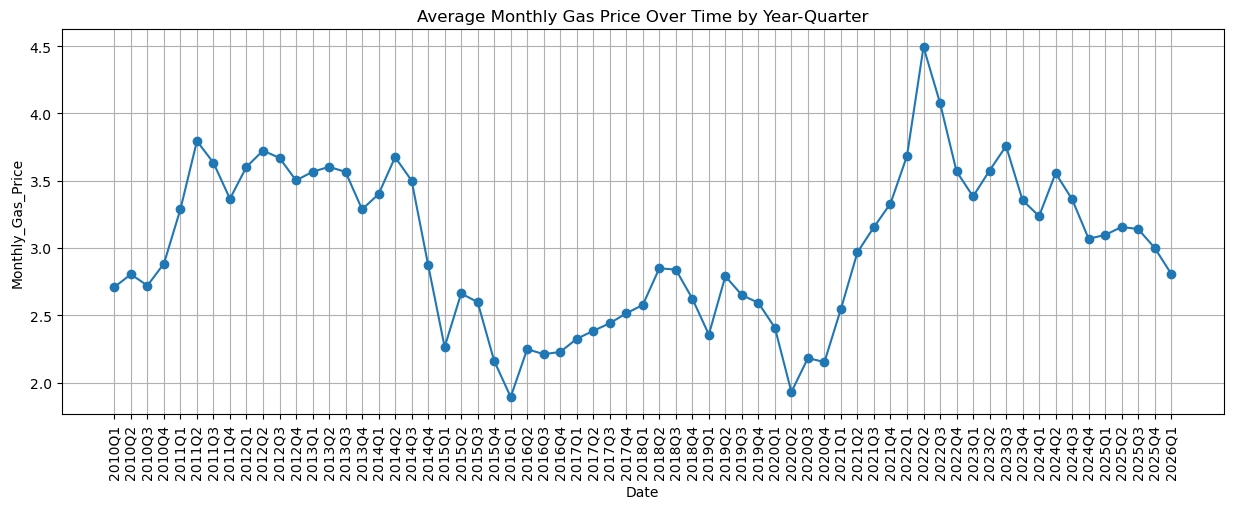

In [20]:
df_cal_quarter = master_df.groupby(by='Year_Quarter').agg({'Monthly_Gas_Price':'mean'}).reset_index()
plot_sales_over_time(df_cal_quarter, 'Year_Quarter', 'Monthly_Gas_Price', 'Average Monthly Gas Price Over Time by Year-Quarter', fig_size=(15,5))

Average Monthly Gas Price Over Time by Year Month


,Year_Month,Monthly_Gas_Price
0,2010-01,2.715
1,2010-02,2.644
2,2010-03,2.772
3,2010-04,2.848
4,2010-05,2.836


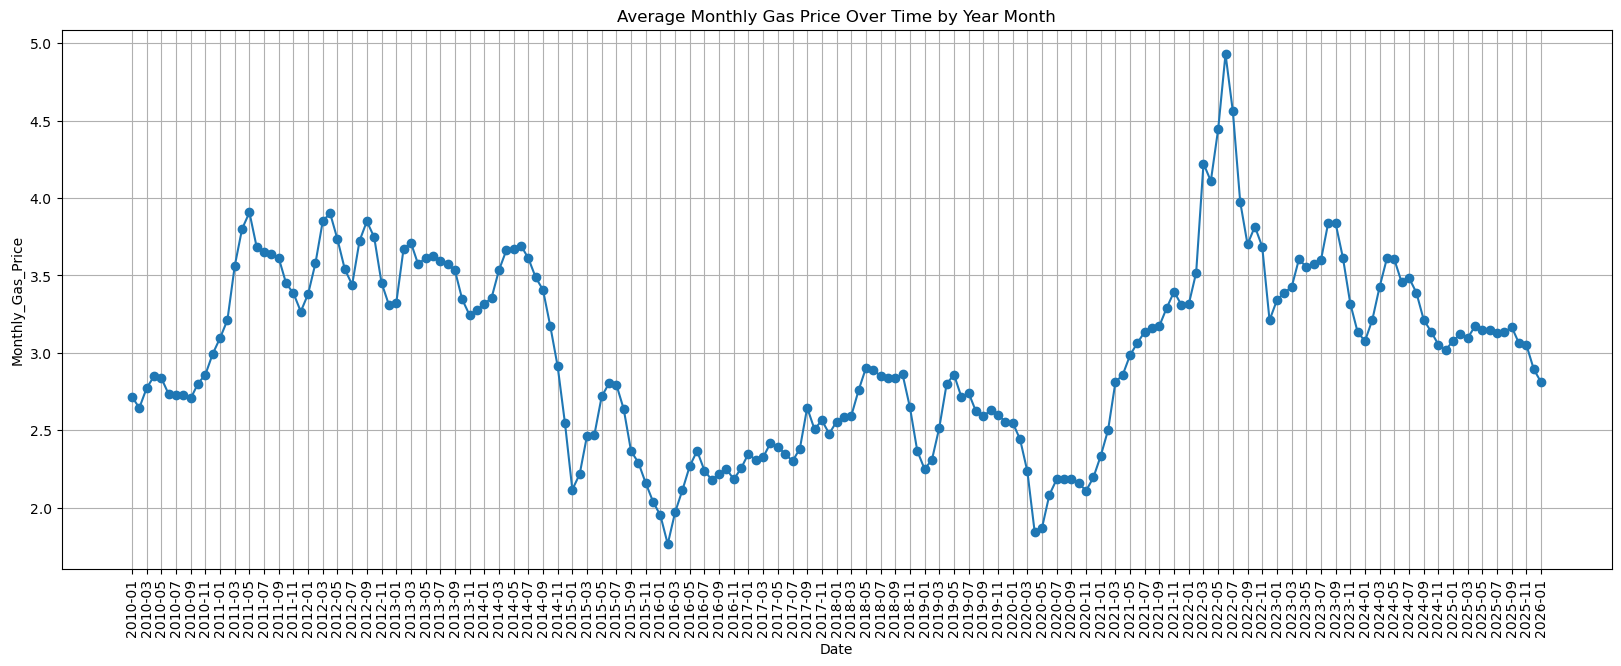

In [21]:
df_cal_monthly = master_df.groupby(by='Year_Month').agg({'Monthly_Gas_Price':'mean'}).reset_index()
# x-axis every 2 months for visualization purposes
range_xticks = df_cal_monthly['Year_Month'].unique()[::2]
# Call the function
plot_sales_over_time(df_cal_monthly, 'Year_Month', 'Monthly_Gas_Price', 'Average Monthly Gas Price Over Time by Year Month', fig_size=(20,7), range_xticks=range_xticks)

**Insights time series graphs**

* Plot average annual gasoline price: The average annual price from 2010 to 2026 didn't show a consistent trend during these 16 years, the price has been fluctuating during this period with upper and lower prices. For instance,  from 2012 to 2016, the price had a constant decrease, reaching its lowest value. After COVID, the price increased, reaching a maximum value in 2022, and decreased again until 2025, when we have a similar average annual price to 2010. 
* Plot average quarter gasoline price: These plots suggest a possible seasonal pattern in the data. We can see that over 16 years, the monthly gasoline price in Q2 of each year is the most expensive compared to the other quarters in the year, followed by a decrease or stability in price, except for 2010, 2017, and the COVID period. This pattern will be confirmed using seasonal decomposition and a statistical test.
* Plot average monthly gasoline price: Displays a very similar behaviour to the annual and quarter average price, with constant months of upper and lower trends. The plot doesn't show any outliers, and the volatility level is very similar across time, except for 2021, when it tends to have more variance. We will consider additional exogenous variables that help us explain these changes in trends. 

Therefore, we propose further analyzing gasoline prices monthly; this is the optimal granularity for forecasting gasoline prices, which would help several industries in their price setting and budgeting processes.

### 4.2 Stationarity testing (ADF)

We will check if the time series is a stationary

In [22]:
def adf_report(series, series_name="series", alpha=0.05):
    result = adfuller(series.dropna())
    test_stat, p_value, used_lag, n_obs, crit_vals, icbest = result

    print(f"\nADF test for {series_name}")
    print("----------------------------")
    print(f"Test statistic : {test_stat:.4f}")
    print(f"p-value        : {p_value:.4f}")
    print(f"Used lags      : {used_lag}")
    print(f"# of obs       : {n_obs}")
    print("Critical values:")
    for k, v in crit_vals.items():
        print(f"  {k}: {v:.4f}")

    print("\nInterpretation:")
    if p_value < alpha:
        print(f"  → p-value < {alpha}, reject H0 (unit root). Series is likely STATIONARY.")
    else:
        print(f"  → p-value ≥ {alpha}, fail to reject H0. Series is likely NONSTATIONARY.")

adf_report(master_df['Monthly_Gas_Price'], series_name="Monthly Gas Price")


ADF test for Monthly Gas Price
----------------------------
Test statistic : -2.4052
p-value        : 0.1403
Used lags      : 2
# of obs       : 190
Critical values:
  1%: -3.4652
  5%: -2.8769
  10%: -2.5749

Interpretation:
  → p-value ≥ 0.05, fail to reject H0. Series is likely NONSTATIONARY.


In [23]:
# Calculate first difference
df_diff_1 = master_df[['Monthly_Gas_Price']].copy()
df_diff_1['Monthly_Gas_Price_diff1'] = df_diff_1['Monthly_Gas_Price'].diff(1)
# drop the first month of 2010
df_diff_1 = df_diff_1.dropna()
adf_report(df_diff_1['Monthly_Gas_Price_diff1'], series_name="Monthly Gas Price First Difference")


ADF test for Monthly Gas Price First Difference
----------------------------
Test statistic : -4.6515
p-value        : 0.0001
Used lags      : 9
# of obs       : 182
Critical values:
  1%: -3.4668
  5%: -2.8776
  10%: -2.5753

Interpretation:
  → p-value < 0.05, reject H0 (unit root). Series is likely STATIONARY.


We can see that the Monthly Gas Price initial data is nonstationary, but after applying the first difference to the time series, we were able to reject the null hypothesis and obtain stationary data. It let us confirm that we need a model capable of first differencing, such as the Holt-Winters Triple, ARIMA, SARIMA, or a transfer function model, among other options.

### 4.3 Check Seasonal decompostion and ACF and PACF plots

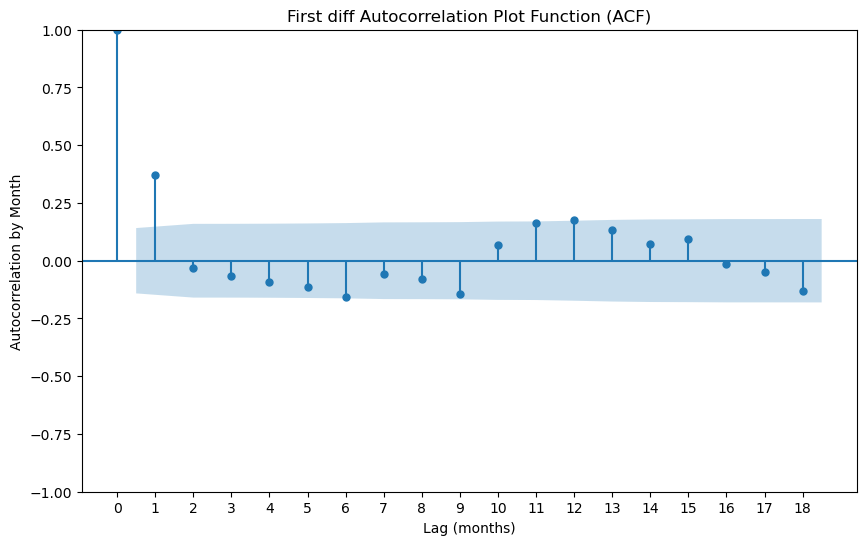

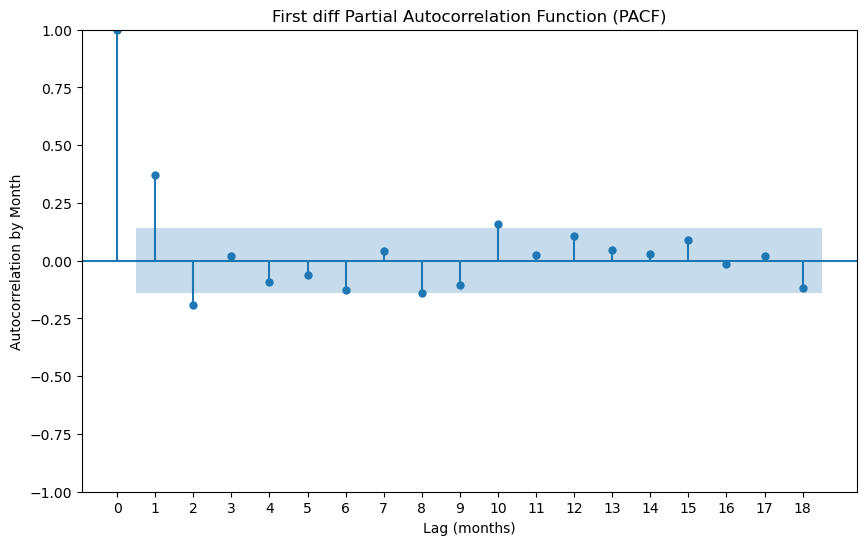

In [24]:
#Generate the autocorrelation plot
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(df_diff_1['Monthly_Gas_Price_diff1'], lags=18, ax=ax)
# Add titles and labels
plt.xlabel('Lag (months)')
plt.ylabel('Autocorrelation by Month')
plt.title('First diff Autocorrelation Plot Function (ACF)')
plt.xticks(range(0,19))
plt.show()

#Generate the autocorrelation plot
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(df_diff_1['Monthly_Gas_Price_diff1'], lags=18, ax=ax)
# Add titles and labels
plt.xlabel('Lag (months)')
plt.ylabel('Autocorrelation by Month')
plt.title('First diff Partial Autocorrelation Function (PACF)')
plt.xticks(range(0,19)) 
plt.show()

The **ACF** and **PCF**, display possible candidates outside the confidence interval, which are lags 1, 2, 6, 8, 10, 12, these apper to be the most significant months. It will be confirmed using the Ljun Box test to verify this visual insight.

**Ljung–Box test for autocorrelation**
* H0 (Null Hypothesis): No autocorrelation up to the specified lag.
* H1 (Alternative Hypothesis): There is autocorrelation up to the specified lag.

In [31]:
lb = acorr_ljungbox(df_diff_1['Monthly_Gas_Price_diff1'], lags=[1, 3, 2, 6, 10, 12], return_df=True)
display(lb)

,lb_stat,lb_pvalue
1,26.674374,2.407940e-07
3,27.734317,4.129590e-06
2,26.854965,1.474071e-06
6,36.979209,1.777398e-06
10,44.094184,3.165887e-06
12,55.855960,1.270526e-07


Considering a significant value of 0.05, **we reject the null hypothesis for all the lags**, indicating the presence of autocorrelation. The lags that are more important to be explored in a future ARIMA model are 1 and 12, which have the lowest p-value and the highest t-statistic.

Possible values for and baseline ARIMA model:
- p: 1, 2, 10 (based on PACF plot)
- d: 1 (based on ADF test)
- q: 1, 6, 12 (based on ACF plot)

### 4.4 Decomposition of Time Series

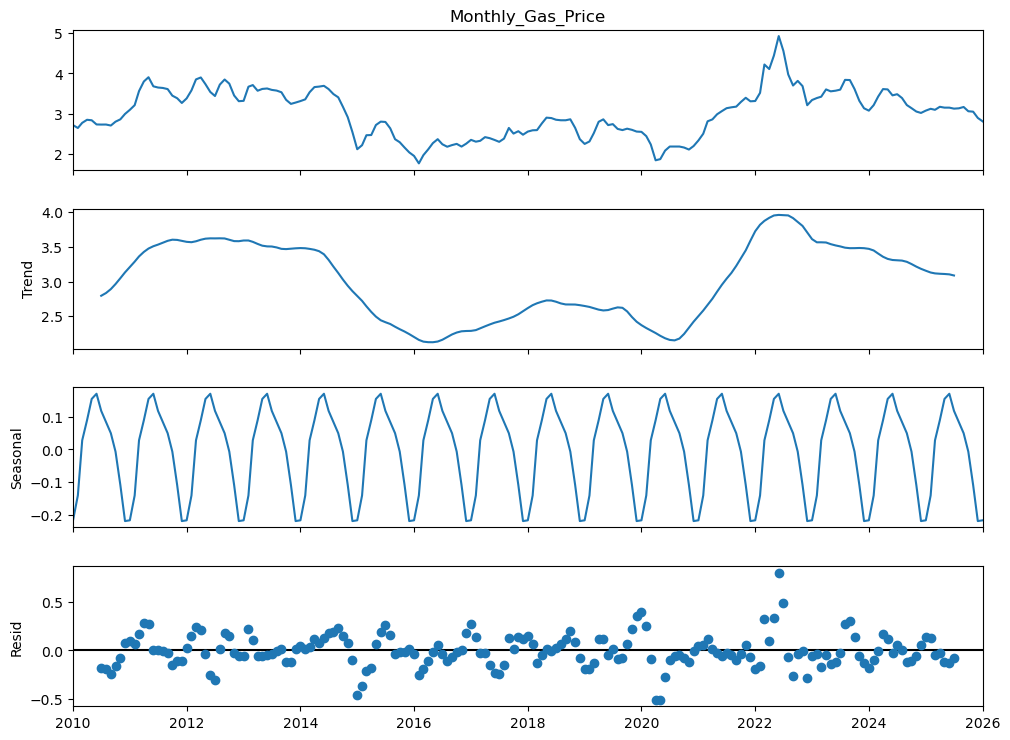

In [34]:
period = 12 # Annual Cycles seasonality with monthly data
decomp = seasonal_decompose(master_df['Monthly_Gas_Price'], model="additive", period=period)
fig = decomp.plot()
fig.set_size_inches(11, 8)
plt.show()

* Trend: As mentioned before, the monthly gasoline prices have upper and lower trends across the time series.
* Seasonal: The graph shows a clear annual seasonality, with peaks around the middle of the year (summer/Q2) and a decrease towards the last quarters of the year. 
* Residual: It displays a possible homoscedastic error (constant variance over time) with some outliers in 2020 and 2022, but it is not concerning as we can add exogenous variables to capture the outliers (e.g., COVID-19 dummy variable).

**Note**: An additive method was applied, since the seasonal fluctuations don't represent a multiplicative effect.

### 4.5 Explore exogenuos variables

In [ ]:
# Possible exogenous variables to consider
master_df.columns

Index(['Gasoline_Stock', 'Monthly_Gas_Price', 'Weekly_Gas_Price',
       'Core_Sticky_CPI', 'import_heavy_sour', 'import_heavy_sweet',
       'import_light_sour', 'import_light_sweet', 'import_medium',
       'miles_traveled_nsa', 'miles_traveled_sa', 'Year', 'Year_Quarter',
       'Year_Month', 'Week'],
      dtype='str')

In [58]:
exo_vars = ['Gasoline_Stock', 'Weekly_Gas_Price',
       'Core_Sticky_CPI', 'import_heavy_sour', 'import_heavy_sweet',
       'import_light_sour', 'import_light_sweet', 'import_medium',
       'miles_traveled_nsa', 'miles_traveled_sa']

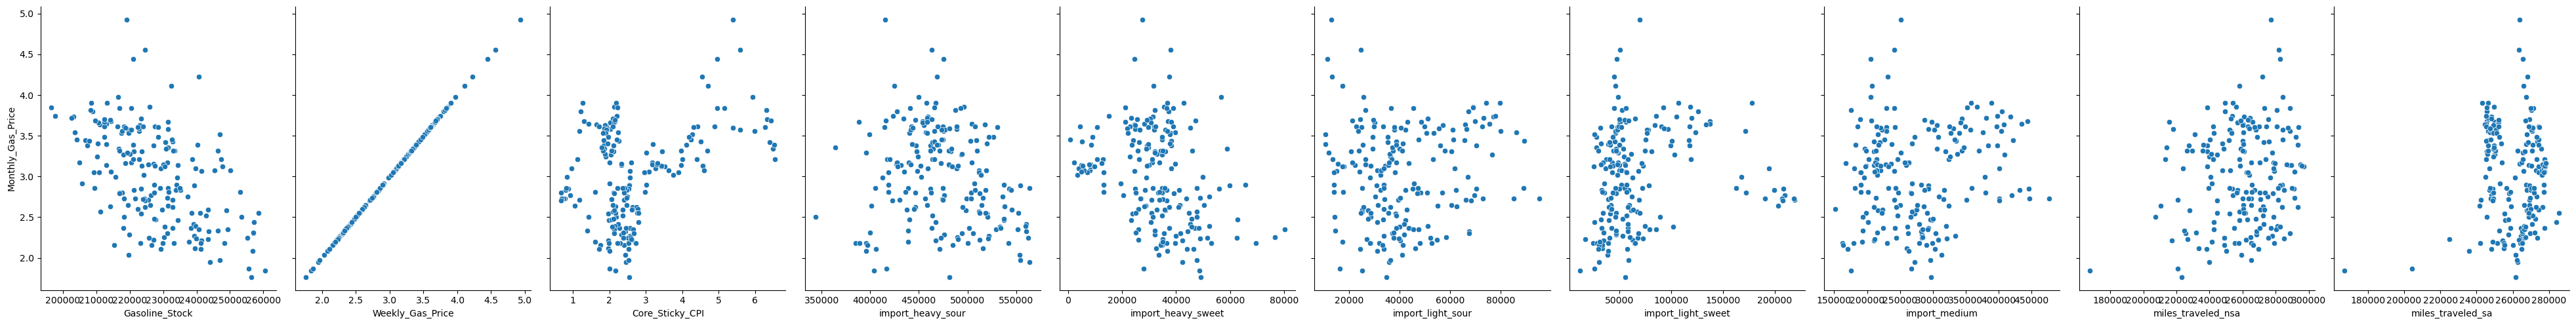

In [59]:
# Plots the target against multiple explanatory variables in one grid
import seaborn as sns
sns.pairplot(master_df, x_vars=exo_vars, y_vars=['Monthly_Gas_Price'], height=5, aspect=0.8)
plt.show()

In [64]:
# Linear correaltion using the pearson coefficient
df_aux = master_df[exo_vars + ['Monthly_Gas_Price']]
features = df_aux.corr()['Monthly_Gas_Price'].sort_values()
features

Gasoline_Stock       -0.542439
import_heavy_sweet   -0.320268
import_heavy_sour    -0.212395
miles_traveled_sa     0.025169
import_light_sour     0.085806
import_light_sweet    0.140951
import_medium         0.150031
miles_traveled_nsa    0.157393
Core_Sticky_CPI       0.391916
Weekly_Gas_Price      1.000000
Monthly_Gas_Price     1.000000
Name: Monthly_Gas_Price, dtype: float64

<Axes: >

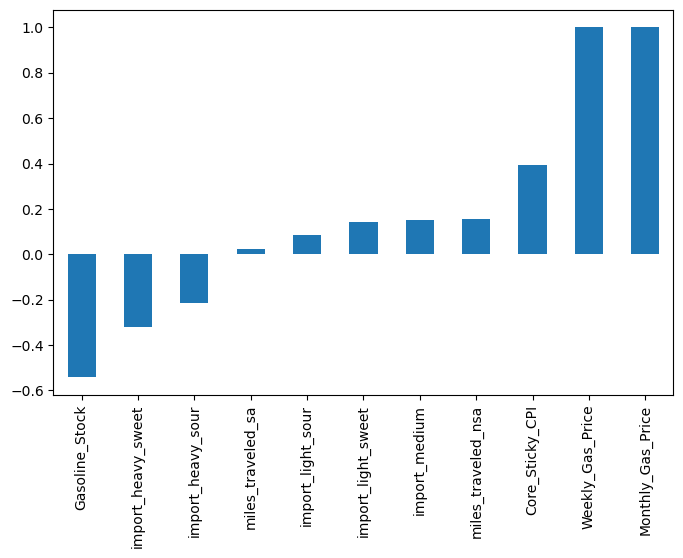

In [66]:
features.plot(kind='bar',figsize=(8,5))

Key variables with strong linear relationship with Monthly_Gas_Price: 

* Positive correlation: Core_sticky, miles_traveled_nsa
* Negative correlation: Gasoline_stock, import_heavy_sour, import_heavy_sweet.

Next steps: we can apply Granger Causality Test to check in better way the correaltion of these variables.